## Тестовое задание. Клекчян Павел
### Классификация заголовков новостей по двум классам: Настоящий, Фейк

### Описание и предобработка данных

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_table('../dataset/train.tsv')

In [3]:
df.head()

title  is_fake
0  Москвичу Владимиру Клутину пришёл счёт за вмеш...        1
1  Агент Кокорина назвал езду по встречке житейск...        0
2  Госдума рассмотрит возможность введения секрет...        1
3  ФАС заблокировала поставку скоростных трамваев...        0
4  Против Навального завели дело о недоносительст...        1

#### Приведем данные к лемме

In [4]:
import re
import nltk
from pymorphy2 import MorphAnalyzer
from pymystem3 import Mystem
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [5]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = stopwords.words('russian')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\79028\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\79028\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
pymorphy = MorphAnalyzer()
mystem = Mystem()

In [7]:
# Приведение к лемме библиотекой Pymystem
def lemma_mystem(string, stopwords):
    lemma_tokens = mystem.lemmatize(string)
    
    if stopwords == True:
        return [i for i in lemma_tokens if (i not in stop_words) and (i != ' ') and (i != '\n')]
    else:
        return [i for i in lemma_tokens if (i != ' ') and (i != '\n')]

In [8]:
# Приведение к лемме библиотекой Pymorphy
def lemma_pymorphy(string, stopwords):
    tokens = string.split()
    
    if stopwords == True:
        tokens = [i for i in tokens if (i not in stop_words)]
        
    lemma_tokens = list(map(lambda x: pymorphy.parse(x)[0].normal_form, tokens))
    
    return lemma_tokens

In [9]:
# Функция приведения текста к лемме
def to_lemma(text, lemmatizer=pymorphy, stopwords=False):
    text = text.lower()
    text = text.replace("ё", "е")
    text = re.sub(r'[^а-я a-z0-9]', '', text)
    
    if lemmatizer == pymorphy:
        lemma_tokens = lemma_pymorphy(text, stopwords)
    elif lemmatizer == mystem:
        lemma_tokens = lemma_mystem(text, stopwords)
        
    return ' '.join(lemma_tokens)

#### Посчитаем кол-во слов в заголовках
#### Считать будем на леммах pymorphy, данная библиотека преобразует слова к леммам гораздо быстрее 

In [10]:
text_lemma = df['title'].apply(to_lemma)
text_lemma_without_stop = df['title'].apply(to_lemma, stopwords=True)

In [11]:
# Считаем количество
def count_words(arr):
    amount_with_stop = arr[0].apply(lambda x: len(x.split()))
    amount_without_stop = arr[1].apply(lambda x: len(x.split()))     
    return [amount_with_stop, amount_without_stop]

In [12]:
# Визуализируем распределение
def show_amount_of_words(arr):
    list_ = count_words(arr)
    
    title = {0:'С стоп словами', 1: 'Без стоп слов'}
    
    plt.figure(figsize=(18,6))
    for i in range(len(list_)):
        plt.subplot(1,2,i+1)
        plt.hist(list_[i], 40, density=True)
        plt.xlabel('Количество слов в заголовке')
        plt.ylabel('Доля заголовков')
        plt.title(title[i])

In [13]:
# Показываем долю заголовком по кол-ву слов
def share_of_words(arr, num_words=(10, 25)):
    list_ = count_words(arr)
    
    data = []
    
    for i in range(num_words[0], num_words[1], 1):
        percent_with_stop = 1-(list_[0]>i).sum()/list_[0].shape[0]
        percent_without_stop = 1-(list_[1]>i).sum()/list_[1].shape[0]
        
        data.append((i, percent_with_stop, percent_without_stop))
    return pd.DataFrame(data, columns=('Кол-во слов до:', 'Доля заголовков со стоп словами', 'Без стоп слов'))

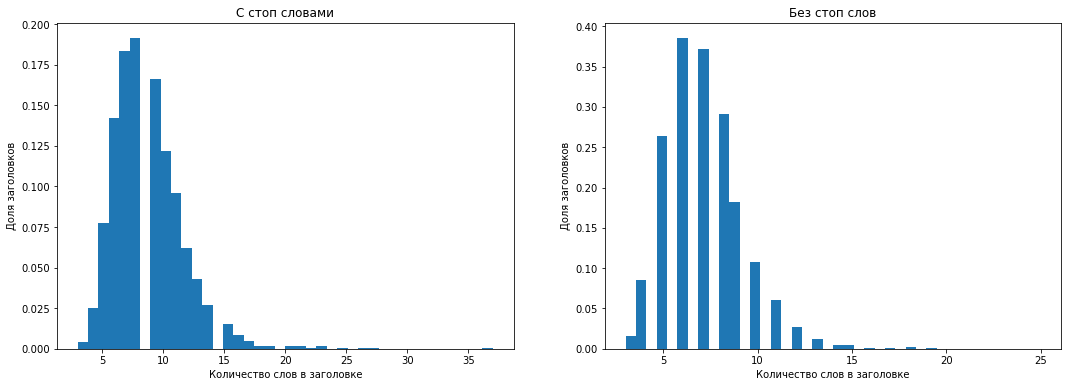

In [14]:
show_amount_of_words([text_lemma, text_lemma_without_stop])

In [15]:
share_of_words([text_lemma, text_lemma_without_stop])

Кол-во слов до:  Доля заголовков со стоп словами  Без стоп слов
0                10                         0.774053       0.936610
1                11                         0.855332       0.969955
2                12                         0.908128       0.984891
3                13                         0.944599       0.991490
4                14                         0.967697       0.994095
5                15                         0.980896       0.996700
6                16                         0.988364       0.997395
7                17                         0.992358       0.997916
8                18                         0.993922       0.998958
9                19                         0.995311       0.999826
10               20                         0.996527       0.999826
11               21                         0.997742       0.999826
12               22                         0.997916       0.999826
13               23                         0.999132       0.999826
14               24                         0.999132       0.999826

#### Как можно увидеть из таблицы, Заголовки со стоп словами длинной до 20 слов покрывают 99.65% всех данных.
#### Заголовки без стоп слов покрывают 99.67% уже с длинной до 15 слов

### Во всех дальнейших моделях будем работать с текстовыми данными на леммах Pymystem без Стоп слов. Сравнение моделей будет на основе F1 метрики

## Классический ML

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC

from tqdm import tqdm

#### Приведем наш текст к леммам. Сохраним результат в файл из-за долгой обработки pymystem

In [17]:
# Использовал при первом обучении, в дальнейшем импортировал предобработанные данные. Можно раскомментить для проверки

# df['title'] = df['title'].apply(to_lemma, lemmatizer=mystem, stopwords=True)
# df.to_csv('prepared_data/mystem_lemma.csv')

In [18]:
df = pd.read_csv('prepared_data/mystem_lemma.csv')

#### Обучение классических моделей будет на основе TF-IDF

#### Создаем корпус по двум классам

In [19]:
data_corp = [ " ".join(df[df['is_fake'] == l]['title'].tolist()) for l in list(df['is_fake'].unique())]

#### Подготавливаем данные с помощью TFIDF

In [20]:
ml_vectorizer = TfidfVectorizer(ngram_range=(1,2))
ml_vectorizer.fit(data_corp)

TfidfVectorizer(ngram_range=(1, 2))

In [21]:
result_tfidf = ml_vectorizer.transform(df['title'].tolist())

In [22]:
X_ml = result_tfidf
y_ml = df['is_fake']

#### Разбиваем на train и test. Во всех последующих моделях будем использовать одинаковую разбивку на train и test

In [23]:
x_train_ml, x_test_ml, y_train_ml, y_test_ml = train_test_split(X_ml, y_ml, test_size=0.2, random_state=42)

### Stecking

#### Stecking будем обучать на SVM, LogisticRegression, KNeighborsClassifier и RidgeClassifier. Были выбраны такие модели из-за разницы типов
#### Для начала найдем лучшие гиперпараметры для этих моделей

In [24]:
all_parametrs=[
    # параметры для KNeighborsClassifier
    {'name':'Knc',"model": KNeighborsClassifier(), 'params':{'n_neighbors':list(range(5,50,5)),
                                                             'weights': ['uniform', 'distance'],
                                                             'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
                                                             'leaf_size':[i for i in range(10, 100, 10)]}},
    
    # параметры для LogisticRegression
    {'name':'Log_reg',"model": LogisticRegression(), 'params':{'C':[0.01, 0.05, 0.1,0.2,0.3,0.5,0.7,1],
                                                               'penalty':['l1', 'l2', 'elasticnet', 'none'],
                                                               'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}},
    
    # параметры для RidgeClassifier
    {'name':'Rc',"model": RidgeClassifier(), 'params':{'alpha':[0.01, 0.05, 0.1,0.2,0.3,0.5,0.7,1],
                                                       'solver':['auto', 'svd', 'cholesky', 'lsqr', 'parse_cg', 'sag', 'saga', 'lbfgs']}},
    
    # параметры для SVC
    {'name':'SVC',"model": SVC(), 'params':{'C':[0.01, 0.05, 0.1,0.2,0.3,0.5,0.7,1],
                                            'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
                                            'gamma':['scale', 'auto']}}]

In [27]:
models={}
for i in tqdm(range(len(all_parametrs))):
    model = GridSearchCV(all_parametrs[i]['model'], all_parametrs[i]['params'], cv=5, scoring='f1')
    model.fit(x_train_ml, y_train_ml)
    
    best_model = model.best_estimator_

    models[all_parametrs[i]['name']] = best_model

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [16:18<00:00, 244.65s/it]


#### Обучение Stacking модели

In [28]:
sr = StackingClassifier(
    [
        ('RidgeCV', models['Rc']),
        ('KNeighborsClassifier', models['Knc']),
        ('SVM', models['SVC'])
    ], 
    models['Log_reg']
)

In [29]:
sr.fit(x_train_ml, y_train_ml)

StackingClassifier(estimators=[('RidgeCV',
                                RidgeClassifier(alpha=0.01, solver='sag')),
                               ('KNeighborsClassifier',
                                KNeighborsClassifier(leaf_size=10)),
                               ('SVM', SVC(C=1, kernel='linear'))],
                   final_estimator=LogisticRegression(C=0.01, penalty='none',
                                                      solver='newton-cg'))

In [30]:
y_pred_ml = sr.predict(x_test_ml)

In [33]:
print(classification_report(y_pred_ml, y_test_ml))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88       593
           1       0.86      0.91      0.88       559

    accuracy                           0.88      1152
   macro avg       0.88      0.88      0.88      1152
weighted avg       0.88      0.88      0.88      1152



#### Stecking модель на кросс валидации

In [34]:
scores_sr = cross_val_score(sr, x_train_ml, y_train_ml, cv=5, scoring='f1')
scores_sr

array([0.87348735, 0.88695652, 0.86975717, 0.90100111, 0.87947883])

In [35]:
scores_sr.mean()

0.8821361969151112



## Deep Learning

#### Для работы с нейронными сетями будем использовать предобученное векторное представление слов Word2vec. 
#### На основе "ruwikiruscorpora_upos_cbow_300_10_2021"

In [36]:
import gensim
import wget
import zipfile

#### Загрузка модели

In [37]:
vectors_model_url = 'http://vectors.nlpl.eu/repository/20/220.zip'

In [ ]:
# Использовал в первый раз, в дальнейшем импортировал
m = wget.download(vectors_model_url)

In [38]:
model_file = vectors_model_url.split('/')[-1]
with zipfile.ZipFile(model_file, 'r') as archive:
    stream = archive.open('model.bin')
    model_word2vec = gensim.models.KeyedVectors.load_word2vec_format(stream, binary=True)

####  Для работы с данной моделью необходимо Тегировать слова - указать часть речи
#### Тегировать будем на основе Pymystem, однако теги нужно будет привести к виду UPos

In [39]:
# Словарь для конвертации
mapping = {'A': 'ADJ', 'ADV': 'ADV', 'ADVPRO': 'ADV',
           'ANUM': 'ADJ', 'APRO': 'DET', 'COM': 'ADJ',
           'CONJ': 'SCONJ', 'INTJ': 'INTJ', 'NONLEX': 'X',
           'NUM': 'NUM', 'PART': 'PART', 'PR': 'ADP', 'S': 'NOUN',
           'SPRO': 'PRON', 'UNKN': 'X', 'V': 'VERB'}

In [40]:
# Функция для тегирования
m = Mystem()
def mystem_tegging(text):
    info = m.analyze(text)
    tag_words = []
    for i in info:
        try:                     
            
            word = i['text']
            if len(i['analysis']) != 0: 
                pos = i["analysis"][0]["gr"].split(',')[0]
                pos = pos.split('=')[0].strip()
            else:
                pos = 'UNKN'
            
            tag_words.append(word + '_' + mapping[pos])
            
        except KeyError:
            continue
            
    return " ".join(tag_words)

#### Тегирование данных

In [41]:
# Использовал при первом обучении, в дальнейшем импортировал предобработанные данные. Можно раскомментить для проверки

# df = pd.read_csv('prepared_data/mystem_lemma.csv')

# df['title'] = df['title'].apply(mystem_tegging)

# df.to_csv('prepared_data/mystem_lemma_tegging.csv')

In [42]:
df = pd.read_csv('prepared_data/mystem_lemma_tegging.csv')

#### Токенизируем данные

In [43]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [44]:
X_nn = df['title'].tolist()
y_nn = np.array(df['is_fake'].tolist())

In [45]:
maxWords = 10000

# Возьмем максимальную длину заголовка 15 токенов. Исходя из анализа данных видим,
# что заголовки с длиной до 15 слов покрывают 99.67% всех данных 
maxLen = 15

In [46]:
nn_tokenizer = Tokenizer(maxWords, filters='', lower=False)
nn_tokenizer.fit_on_texts(X_nn)

In [47]:
data = nn_tokenizer.texts_to_sequences(X_nn)

# Подгоняем все наши семплы под длину maxLen (удаляем лишнее или добавляем нули при недостатке)
data = pad_sequences(data, maxLen)

#### Embedding Matrix

In [48]:
words = list(model_word2vec.index_to_key)

In [49]:
DIM = model_word2vec.vector_size 

# Инициализируем матрицу embedding слоя нулями
embedding_matrix = np.zeros((maxWords, DIM))

# Заполняем матрицу предобученными векторами по словам в нашем датасете
for word, i in nn_tokenizer.word_index.items():
    if i >= maxWords:
        break
    if word in words:
        embedding_matrix[i] = model_word2vec[word]

#### Разбиваем данные на train и test (Используем те же значения параметров для разбиения на идентичные наборы в разных моделях)

In [50]:
x_train_nn, x_test_nn, y_train_nn, y_test_nn = train_test_split(data, y_nn, test_size=0.2, random_state=42)

### Нейронная сеть

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, MaxPooling1D, Conv1D,Flatten, SimpleRNN, LSTM, GRU, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l1, l2
from keras import backend as K

import kerastuner as kt
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization

#### Функция для F1_score

In [52]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### Создаем модель

In [65]:
model_nn = Sequential()
model_nn.add(Embedding(maxWords, 64, input_length=maxLen))
# model_nn.add(Embedding(maxWords, DIM, input_length=maxLen,
#                           weights=[embedding_matrix], trainable=False))

model_nn.add(GRU(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model_nn.add(GRU(64, dropout=0.2, recurrent_dropout=0.2))
model_nn.add(Dense(32, activation='relu'))
model_nn.add(Dropout(0.5))

model_nn.add(Dense(1, activation='sigmoid'))

model_nn.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=[f1_m, precision_m, recall_m])

In [66]:
model_nn_save_path = 'best_model.h5'
checkpoint_callback = ModelCheckpoint(model_nn_save_path,
                                     monitor='val_f1_m',
                                     save_best_only=True)

In [67]:
history = model_nn.fit(x_train_nn, 
                    y_train_nn, 
                    epochs=10,
                    batch_size=512,
                    validation_split=0.2,
                    callbacks=[checkpoint_callback],
                    verbose=1)

Epoch 1/10
8/8 [==============================] - 7s 352ms/step - loss: 0.6899 - f1_m: 0.6122 - precision_m: 0.5530 - recall_m: 0.6930 - val_loss: 0.6773 - val_f1_m: 0.6550 - val_precision_m: 0.8849 - val_recall_m: 0.5199
Epoch 2/10
8/8 [==============================] - 2s 236ms/step - loss: 0.6542 - f1_m: 0.6568 - precision_m: 0.8677 - recall_m: 0.5386 - val_loss: 0.5933 - val_f1_m: 0.8034 - val_precision_m: 0.8148 - val_recall_m: 0.7923
Epoch 3/10
8/8 [==============================] - 2s 230ms/step - loss: 0.5155 - f1_m: 0.8005 - precision_m: 0.8531 - recall_m: 0.7559 - val_loss: 0.4358 - val_f1_m: 0.8008 - val_precision_m: 0.8684 - val_recall_m: 0.7431
Epoch 4/10
8/8 [==============================] - 2s 235ms/step - loss: 0.3575 - f1_m: 0.8592 - precision_m: 0.8887 - recall_m: 0.8364 - val_loss: 0.4088 - val_f1_m: 0.8214 - val_precision_m: 0.7777 - val_recall_m: 0.8705
Epoch 5/10
8/8 [==============================] - 2s 235ms/step - loss: 0.2274 - f1_m: 0.9250 - precision_m: 0.9

#### Посмотрим на обучение

In [56]:
def show_quality(history):
    plt.plot(history.history['f1_m'], 
         label='f1 обучающем наборе')
    plt.plot(history.history['val_f1_m'], 
             label='f1 на проверочном наборе')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('f1_мера')
    plt.legend()
    plt.show()

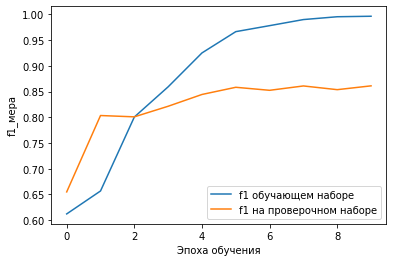

In [68]:
show_quality(history)

In [69]:
model_nn.evaluate(x_test_nn, y_test_nn, verbose=1)

36/36 [==============================] - 1s 6ms/step - loss: 0.7001 - f1_m: 0.8365 - precision_m: 0.8532 - recall_m: 0.8272


[0.7000917792320251, 0.8365371823310852, 0.853155255317688, 0.8272272944450378]

In [70]:
def get_score_nn(model, x_test, y_test):
    pred = model.predict(x_test)
    arr = []
    for i in pred:
        if i >= 0.5:
            arr.append(1)
        else:
            arr.append(0)
            
    print(classification_report(y_test, arr))
    return arr

In [71]:
y_pred_nn = get_score_nn(model_nn, x_test_nn, y_test_nn)

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       562
           1       0.86      0.83      0.85       590

    accuracy                           0.84      1152
   macro avg       0.84      0.84      0.84      1152
weighted avg       0.85      0.84      0.84      1152



In [72]:
f1_nn = f1_score(y_test_nn, y_pred_nn)
f1_nn

0.8460877042132416

### Обуздать Нейронные сети на данном этапе не удалось. Обучение сети на предобученном Embedding показывает результат хуже, чем при построении нового Embedding на корпусе данных тестового задания

### Для предсказания данных text.tsv мною выбран Ансамбль моделей - Stecking. Обоснованно значениями метрик F1, precision, recall

### Предсказание тестового набора данных

In [91]:
df_test = pd.read_table('../dataset/test.tsv')

#### Подготавливаем данные для предсказания

In [92]:
data_test = df_test['title'].apply(to_lemma, lemmatizer = mystem, stopwords=True)

In [96]:
data_test = ml_vectorizer.transform(data_test.tolist())

#### Предсказываем класс

In [97]:
test_pred = sr.predict(data_test)

In [98]:
df_test['is_fake'] = pd.Series(test_pred)

#### Сохраняем test.tsv с предсказанными значениями

In [99]:
df_test.to_csv('../predictions.tsv', index=False, sep="\t")